# LOAD LIBRARIES

In [15]:
import sys
from pathlib import Path
sys.path.append(str(Path("../").resolve()))

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np



---



# LOAD DATA

In [16]:
data_folder = "../data"
data_path = f"{data_folder}/era5_1960to2020_17feats_standard.csv"
era5 = pd.read_csv(data_path)

era5['time'] = pd.to_datetime(era5['time'], format="%m-%d-%Y")
era5 = era5.set_index('time')
era5.head().T

time,1960-01-01,1960-01-02,1960-01-03,1960-01-04,1960-01-05
10m_u_component_of_wind,-5.273945e+00,-3.699429,1.705438e+00,-1.406776,-3.580756e+00
10m_v_component_of_wind,-1.630001e+00,0.139696,-3.226488e+00,-3.184707,-1.209632e+00
2m_temperature,2.844731e+02,286.790530,2.862962e+02,281.743960,2.847674e+02
divergence,6.746101e-07,-0.000002,9.848103e-07,0.000001,6.520804e-07
geopotential,7.983778e+04,80214.805000,8.039277e+04,80548.125000,8.056355e+04
mean_sea_level_pressure,1.015583e+05,101497.780000,1.017527e+05,102363.530000,1.021426e+05
relative_humidity,3.938073e-01,0.397636,4.419897e-01,0.346748,4.013636e-01
specific_humidity,2.248733e-03,0.002394,2.275220e-03,0.001291,2.202011e-03
temperature,2.467003e+02,247.725740,2.471930e+02,246.255360,2.469128e+02
total_cloud_cover,9.278467e-01,0.953978,7.083167e-01,0.752043,8.781669e-01




---



# EXPLORATORY DATA ANALYSIS

In [17]:
era5.describe().T

,count,mean,std,min,25%,50%,75%,max
10m_u_component_of_wind,22281.0,-5.399636e-01,2.280359,-11.229872,-2.159858e+00,-5.997251e-01,1.061685e+00,9.416750
10m_v_component_of_wind,22281.0,2.734969e-01,2.702625,-10.272203,-1.448576e+00,5.510672e-01,2.146743e+00,12.396901
2m_temperature,22281.0,2.935348e+02,6.528363,266.423500,2.889232e+02,2.945624e+02,2.993422e+02,304.796750
divergence,22281.0,6.049062e-08,0.000002,-0.000007,-9.463977e-07,-2.341414e-08,9.458533e-07,0.000010
geopotential,22281.0,8.075631e+04,865.332758,77600.360000,8.011287e+04,8.077466e+04,8.151697e+04,82569.164000
mean_sea_level_pressure,22281.0,1.017320e+05,478.741119,98415.200000,1.014343e+05,1.016880e+05,1.019927e+05,104163.460000
relative_humidity,22281.0,3.630271e-01,0.116500,0.094175,2.722392e-01,3.588292e-01,4.474528e-01,0.719251
specific_humidity,22281.0,2.728713e-03,0.001243,0.000222,1.681800e-03,2.743581e-03,3.794679e-03,0.006607
temperature,22281.0,2.490121e+02,2.694849,239.765900,2.469418e+02,2.490710e+02,2.515022e+02,255.708500
total_cloud_cover,22281.0,5.081301e-01,0.309858,0.000000,2.367338e-01,5.084177e-01,7.828501e-01,1.000000


In [18]:
era5.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22281 entries, 1960-01-01 to 2020-12-31
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   10m_u_component_of_wind    22281 non-null  float64
 1   10m_v_component_of_wind    22281 non-null  float64
 2   2m_temperature             22281 non-null  float64
 3   divergence                 22281 non-null  float64
 4   geopotential               22281 non-null  float64
 5   mean_sea_level_pressure    22281 non-null  float64
 6   relative_humidity          22281 non-null  float64
 7   specific_humidity          22281 non-null  float64
 8   temperature                22281 non-null  float64
 9   total_cloud_cover          22281 non-null  float64
 10  total_column_water_vapour  22281 non-null  float64
 11  u_component_of_wind        22281 non-null  float64
 12  v_component_of_wind        22281 non-null  float64
 13  vertical_velocity          22

In [20]:
cols = list(era5.columns)
cols

['10m_u_component_of_wind',
 '10m_v_component_of_wind',
 '2m_temperature',
 'divergence',
 'geopotential',
 'mean_sea_level_pressure',
 'relative_humidity',
 'specific_humidity',
 'temperature',
 'total_cloud_cover',
 'total_column_water_vapour',
 'u_component_of_wind',
 'v_component_of_wind',
 'vertical_velocity',
 'wind_speed',
 'total_precipitation']

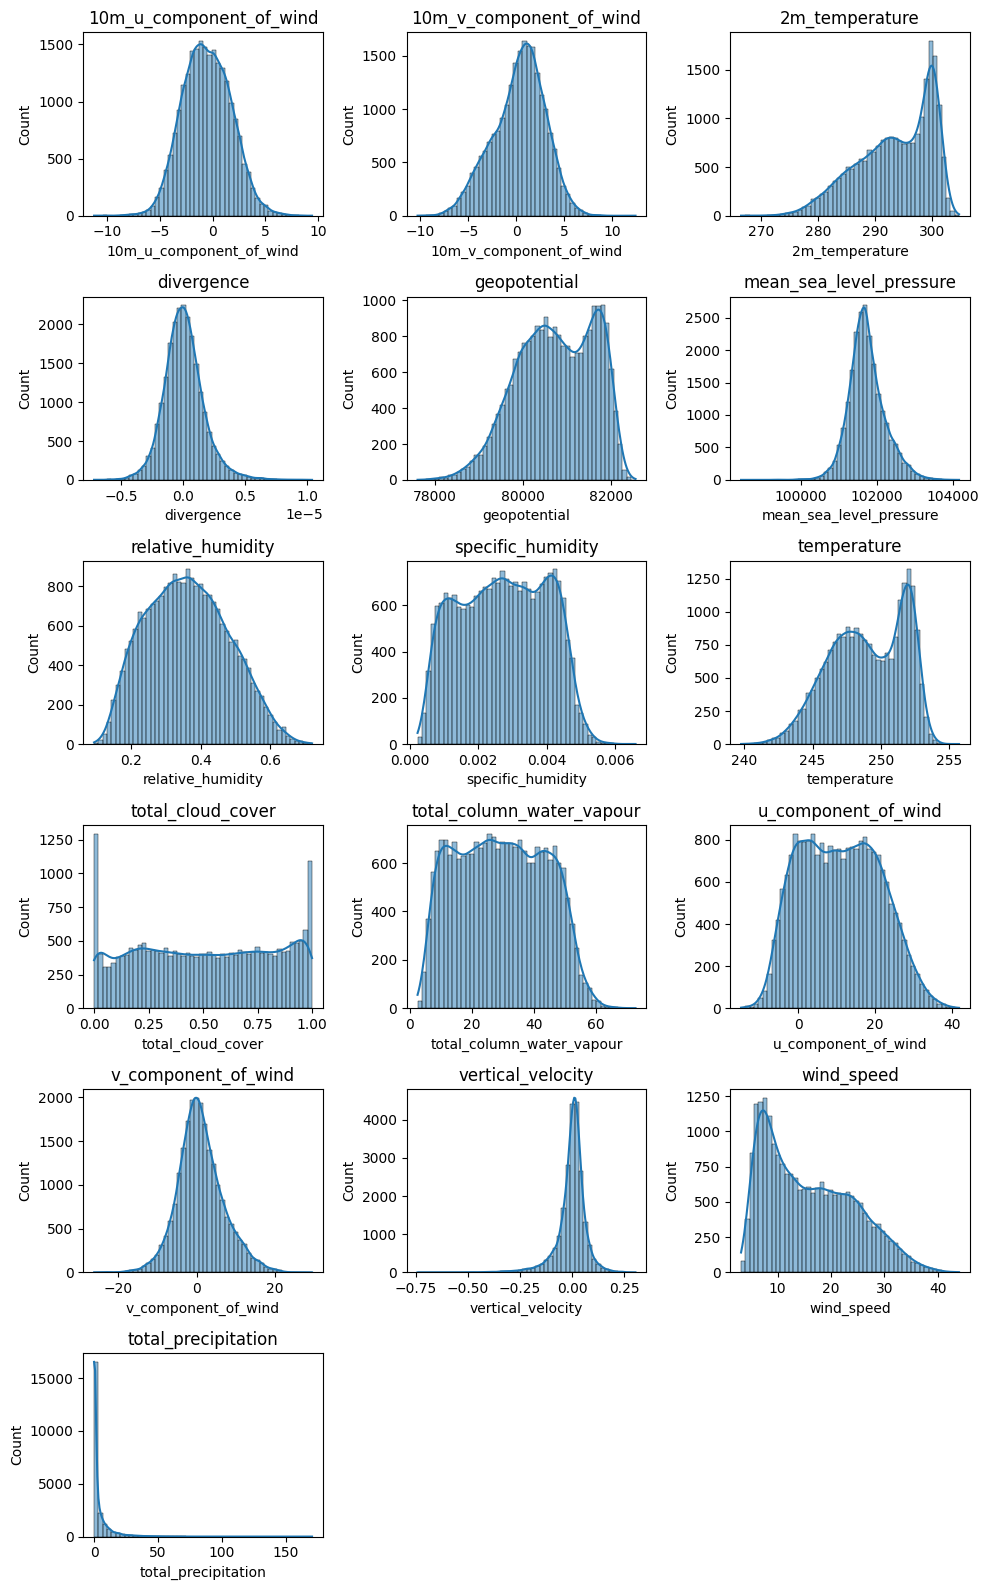

In [21]:
fig, axes = plt.subplots(len(cols)//3 + 1, 3, figsize=(10, 16))
axes = axes.flatten()

for i, var in enumerate(cols):
    sns.histplot(era5[var], bins=50, ax=axes[i], kde=True)
    axes[i].set_title(f"{var}")

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

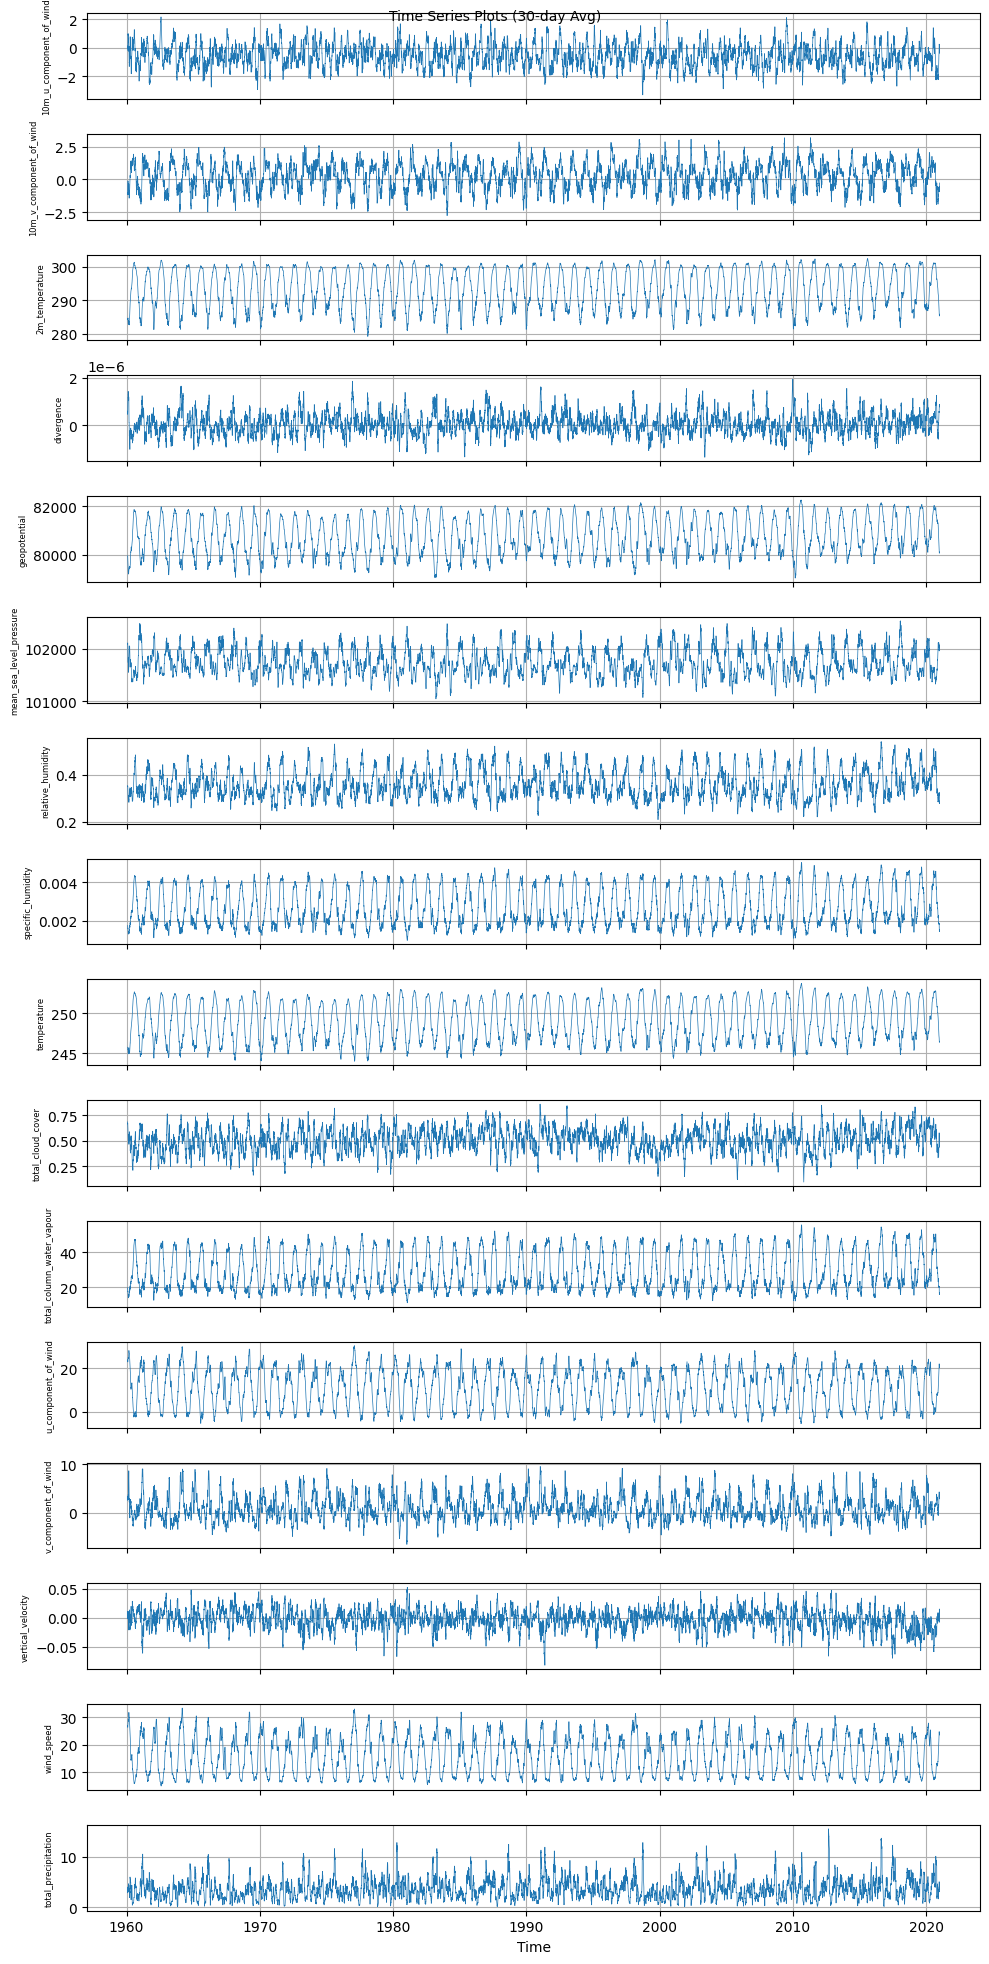

In [24]:
rolling_30 = era5.rolling(window=30).mean()

fig, axes = plt.subplots(len(cols), 1, figsize=(10, 20), sharex=True)
for i, var in enumerate(cols):
    axes[i].plot(rolling_30.index, rolling_30[var], linewidth=.5)
    axes[i].set_ylabel(var, fontsize=6)
    axes[i].grid(True)

axes[-1].set_xlabel("Time")
plt.suptitle("Time Series Plots (30-day Avg)", fontsize=10)
plt.tight_layout()
plt.show()

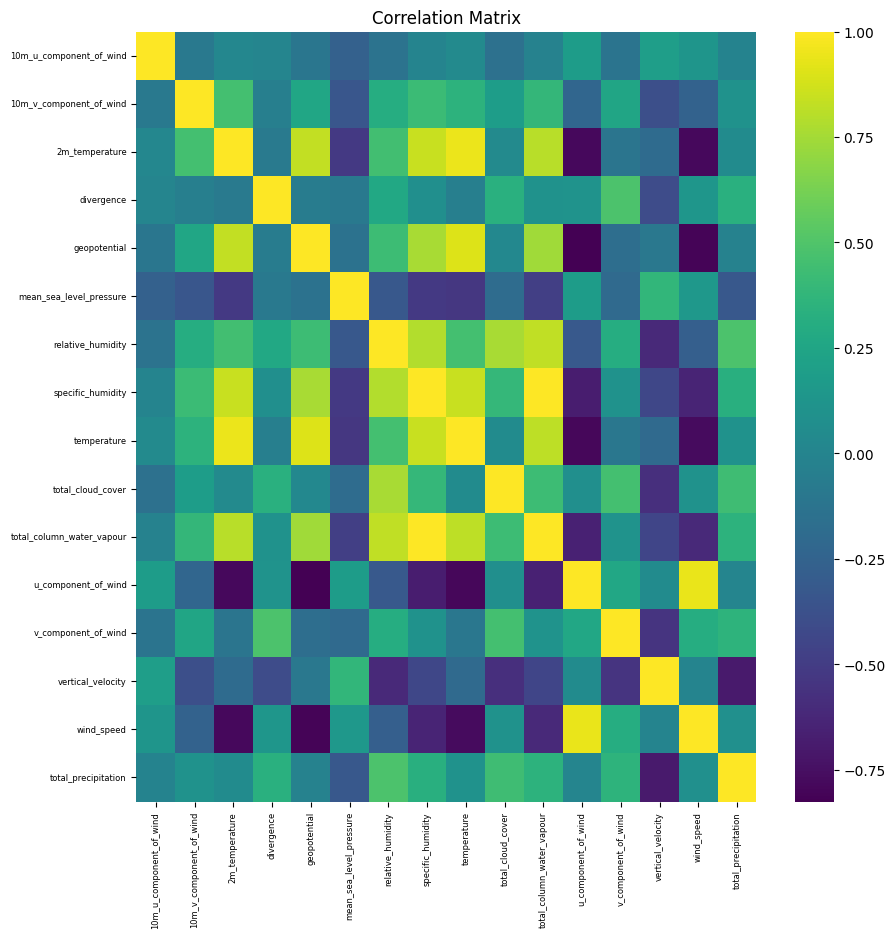

In [26]:
corr = era5.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='viridis')
plt.title("Correlation Matrix")
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.show()

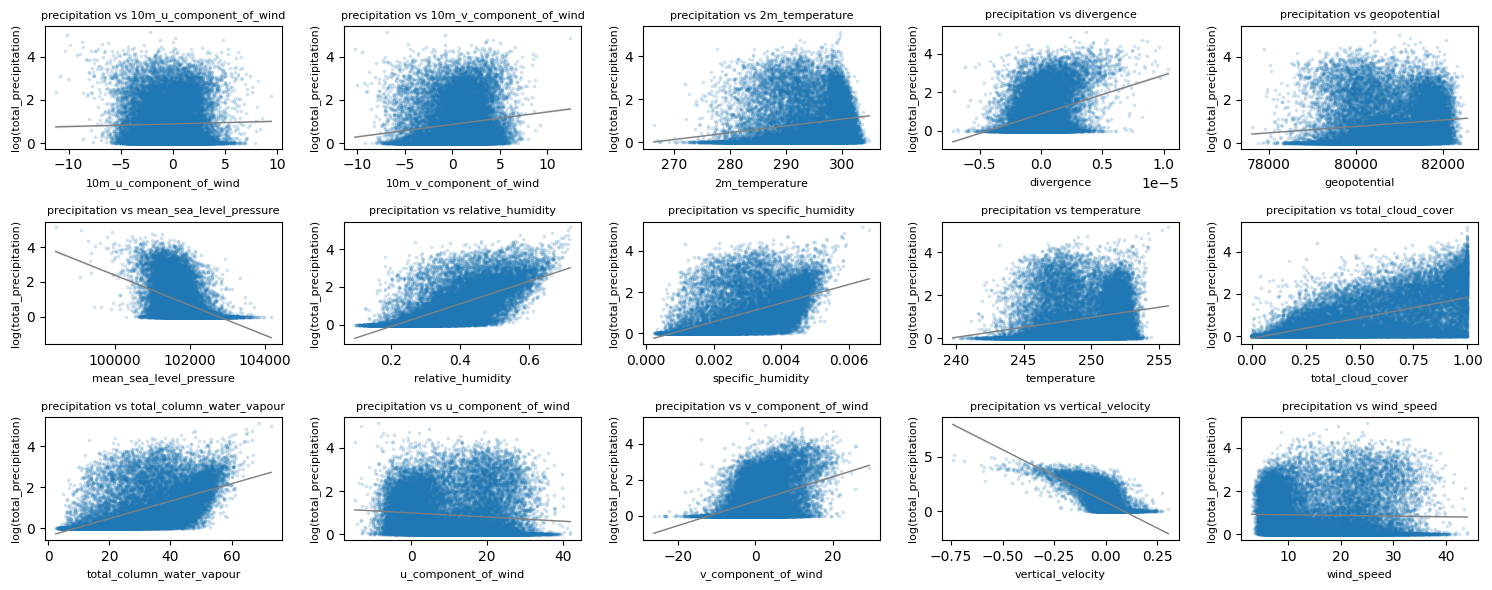

In [29]:
vars_to_plot = [v for v in era5.columns if v not in ["total_precipitation"]]

num_vars = len(vars_to_plot)
cols = 5
rows = int(np.ceil(num_vars / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 2 * rows))
axes = axes.flatten()

log_precip = np.log1p(era5["total_precipitation"])

for i, var in enumerate(vars_to_plot):
    sns.regplot(
        x=era5[var],
        y=log_precip,
        ax=axes[i],
        scatter_kws={"alpha": 0.15, "s": 3},
        line_kws={"color": "gray", "linewidth": 1},
        lowess=False,
        order=1
    )

    axes[i].set_title(f"precipitation vs {var}", fontsize=8)
    axes[i].set_xlabel(var, fontsize=8)
    axes[i].set_ylabel("log(total_precipitation)", fontsize=8)

for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



---

